### Image denoising via Gibbs sampling 

In this notebook we demonstrate how Gibbs sampling can be used for image denoising. (While this was one of the original uses proposed for Gibbs sampling, there are now much better algorithms and theory -- this is just for demonstration purposes!)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
%matplotlib inline


The Ising model is central to physics, social network analysis, 
and many other domains.

Each node $i$ in a graph is takes a value $Z_i \in\{-1, 1\}$ that is either 1 or -1. In this version of the model,
the joint probability takes the form 

$$p(Z) \;\propto\; \exp\left(\sum_{(i,j)\in E} \beta Z_i Z_j\right)$$

where $\beta$ is a scalar parameter, assigning a weight to each edge $(i,j)\in E$ in a graph. Each node $(x,y)$ is connected to the 
nodes that are immediately above, below, left, and right, as shown here:

<img src="gridgraph.png" width="250">

The Gibbs sampling algorithm samples from such a distribution by 
repeatedly visiting each node $i$, and sampling $Z_i$ while holding 
all of the other $Z_j$'s fixed. 

The following code implements Gibbs sampling for this model. 


In [2]:
def gibbs_step(Z, beta, x, y):
    exponent = 0
    for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
        if ((x + dx < 0) | (x + dx >= Z.shape[0]) | 
            (y + dy < 0) | (y + dy >= Z.shape[1])): 
            continue
        exponent += beta * Z[x+dx, y+dy]

    # set p
    p = 1/(1+np.exp(-2*exponent))
    
    # draw a random uniform variable
    if np.random.rand() <= p:
        Z_new = 1
    else:
        Z_new = -1
        
    return Z_new

In [3]:
def run_gibbs_sampling(Z, beta, steps=10):
    for _ in np.arange(steps*np.prod(Z.shape)):
        x = np.random.choice(range(Z.shape[0]))
        y = np.random.choice(range(Z.shape[0]))
        Z[x, y] = gibbs_step(Z, beta, x, y)

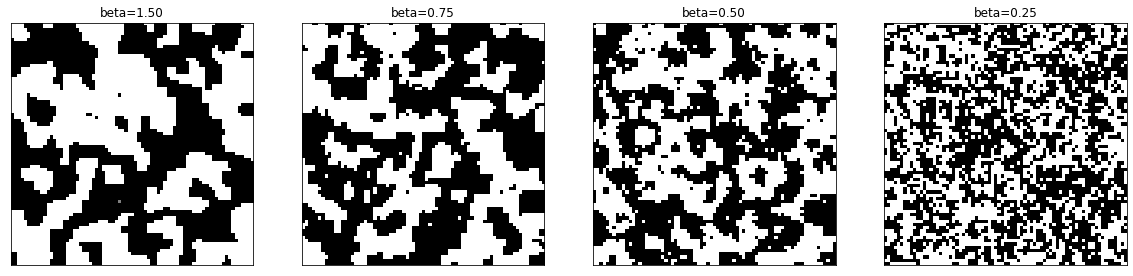

In [4]:
size = 75
fig = plt.figure(figsize=(20,5), edgecolor='black')

betas = np.array([1.5, 0.75, 0.50, 0.25])
for i in np.arange(len(betas)):
    beta = betas[i]
    Z = np.zeros(size*size).reshape(size, size)
    run_gibbs_sampling(Z, beta)
    
    # plot the results
    ax = fig.add_subplot(1, len(betas), i+1)
    ax.set_title("beta=%2.2f" % beta)
    axim = ax.imshow(Z, vmin=-1, vmax=1, cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
    


In [5]:
def gibbs_denoise_image(fn, eps=.1, beta=1.5, steps=1e6):
    
    # read image and convert to binary
    im = plt.imread(fn)
    if (len(im.shape) == 3):
        im = im[:,:,0]
    im = np.array(im > np.mean(im), dtype=np.int64)
    
    dim = np.prod(im.shape)
    noise = np.random.choice([0,1], p=[1-eps, eps], size=dim).reshape(im.shape)
    Z = (im + noise) % 2
    Z = 2*Z - 1
    
    steps_per_show = 1000
    Z0 = Z.copy()
    for step in np.arange(steps+1):
        x = np.random.choice(range(Z.shape[0]))
        y = np.random.choice(range(Z.shape[1]))
        Z[x, y] = gibbs_step(Z, beta, x, y)
    
    
        # print progress periodically
        if step % steps_per_show == 0:
            clear_output(wait=True)
            plt.figure(figsize=(12,8))
            plt.subplot(1,3,1)
            plt.imshow(im, cmap='gray')
            plt.title('original')
            plt.axis('off')    
            plt.subplot(1,3,2)
            plt.imshow(Z0, cmap='gray')
            plt.title('noisy')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.imshow(Z, cmap='gray')
            plt.title('Gibbs step: %d' % step)
            plt.axis('off')
            plt.show()

    

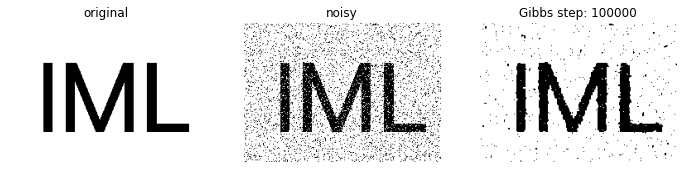

In [9]:
fn = 'https://raw.githubusercontent.com/YData123/sds365-fa22/main/demos/gibbs_sampling/iml.png'
gibbs_denoise_image(fn, eps=.1, beta=1.5, steps=100000)

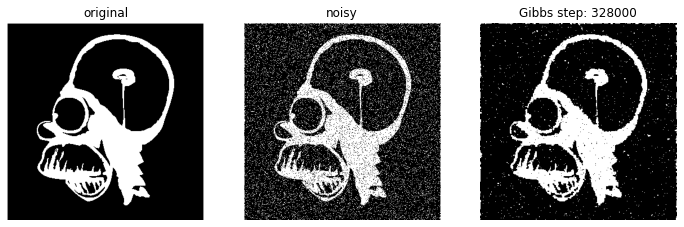

In [ ]:
fn = 'https://raw.githubusercontent.com/YData123/sds365-fa22/main/demos/gibbs_sampling/homer-brain.png'
gibbs_denoise_image('homer-brain.jpg', eps=.1, beta=1.5, steps=5e5)